In [34]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [36]:
def generate_24hr_engine_data_realistic(seed=42):
    """
    Generate 24-hour synthetic engine data with improved realism:
    - Throttle has delayed effect on RPM (inertia)
    - RPM affects pressure, temperature with lag
    - Adds physical noise, resonance, ambient effects
    - Reduces artificial correlations
    """

    np.random.seed(seed)

    duration_min = 24 * 60
    step_sec = 30
    total_points = duration_min * 60 // step_sec  # 2880

    time = np.arange(0, total_points * step_sec, step_sec)

    # -- Phase pattern: idle, cruise, ramp, cooldown
    pattern = [0]*60 + [1]*100 + [2]*40 + [3]*40
    phases = (pattern * ((total_points // len(pattern)) + 1))[:total_points]

    # -- Throttle profile
    throttle = np.zeros(total_points)
    for i, phase in enumerate(phases):
        if phase == 0:  # idle
            throttle[i] = np.random.uniform(5, 20)
        elif phase == 1:  # cruise
            throttle[i] = np.random.uniform(35, 55)
        elif phase == 2:  # ramp
            throttle[i] = np.random.uniform(65, 100)
        elif phase == 3:  # cooldown
            throttle[i] = np.random.uniform(0, 10)

    # Smooth throttle transitions
    for i in range(1, total_points):
        max_delta = 10
        diff = throttle[i] - throttle[i-1]
        if abs(diff) > max_delta:
            throttle[i] = throttle[i-1] + np.sign(diff) * max_delta

    # -- Initialize arrays
    rpm = np.zeros(total_points)
    temp = np.zeros(total_points)
    pressure = np.zeros(total_points)
    vibration = np.zeros(total_points)

    # Initial conditions
    rpm[0] = 850
    temp[0] = 70
    pressure[0] = 1.6
    vibration[0] = 0.18

    for i in range(1, total_points):
        dt = step_sec

        # ===== RPM =====
        target_rpm = 800 + throttle[i]**1.05 * 2.2 + np.random.normal(0, 25)
        inertia = 0.3
        rpm[i] = rpm[i-1] + inertia * (target_rpm - rpm[i-1])
        rpm[i] = np.clip(rpm[i], 700, 6500)

        # ===== Temperature =====
        heat_from_rpm = (rpm[i] - 800) * 0.002
        heat_from_throttle = throttle[i] * 0.05
        ambient_cooling = 0.02 * (temp[i-1] - 20)
        temp[i] = temp[i-1] + 0.1 * (heat_from_rpm + heat_from_throttle - ambient_cooling)
        temp[i] += np.random.normal(0, 1.5)
        temp[i] = np.clip(temp[i], 60, 130)

        # ===== Pressure =====
        base = 1.3 + (throttle[i]/100)**1.25 * 2.1 + (rpm[i] / 6000) * 0.8
        pressure[i] = pressure[i-1] + 0.25 * (base - pressure[i-1]) + np.random.normal(0, 0.05)
        pressure[i] = np.clip(pressure[i], 1.0, 4.2)

        # ===== Vibration (improved) =====
        norm_throttle = throttle[i] / 100
        norm_rpm = (rpm[i] - 700) / (6500 - 700)
        base_vib = 0.12 + 0.25 * (0.7 * norm_throttle + 0.3 * norm_rpm)**1.3

        resonance = 0
        if 2900 < rpm[i] < 3300:
            resonance += 0.03 * np.sin((rpm[i] - 3000) * 0.02)
        if 4700 < rpm[i] < 5100:
            resonance += 0.025 * np.sin((rpm[i] - 4900) * 0.03)

        sinusoidal = 0.01 * np.sin(2 * np.pi * i / 48)  # 24-min cycle
        throttle_spike = abs(throttle[i] - throttle[i-1]) * 0.004
        noise = np.random.normal(0, 0.007)

        vibration[i] = base_vib + resonance + sinusoidal + throttle_spike + noise
        vibration[i] = np.clip(vibration[i], 0.12, 0.42)

    return pd.DataFrame({
        "t_sec": time,
        "throttle_pos": throttle.round(1),
        "rpm": rpm.astype(int),
        "coolant_temp": temp.round(1),
        "pressure": pressure.round(2),
        "vibration": vibration.round(3)
    })



In [37]:
df = generate_24hr_engine_data_realistic()
df.head()


,t_sec,throttle_pos,rpm,coolant_temp,pressure,vibration
0,0,10.6,850,70.0,1.60,0.180
1,30,19.3,856,69.4,1.49,0.177
2,60,16.0,854,70.0,1.59,0.144
3,90,14.0,854,71.7,1.50,0.148
4,120,7.3,839,71.6,1.51,0.154


In [38]:
def prepare_lstm_dataset(df, input_features, target_features, window_size=10):
    # Normalize data
    input_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    input_data = input_scaler.fit_transform(df[input_features])
    target_data = target_scaler.fit_transform(df[target_features])

    X_seq, y_seq = [], []
    for i in range(window_size, len(df)):
        X_seq.append(input_data[i - window_size:i])
        y_seq.append(target_data[i])

    return (
        np.array(X_seq),
        np.array(y_seq),
        input_scaler,
        target_scaler
    )


In [39]:
input_features = ["throttle_pos", "rpm", "coolant_temp", "pressure", "vibration"]
target_features = ["rpm", "coolant_temp", "pressure", "vibration"]
window_size = 20  # or whatever you used in `create_supervised_dataset`

In [40]:
# Define features and window size
input_features = ["throttle_pos", "rpm", "coolant_temp", "pressure", "vibration"]
target_features = ["rpm", "coolant_temp", "pressure", "vibration"]
window_size = 10  # Or any other value you want

# P
X, y, input_scaler, target_scaler = prepare_lstm_dataset(
    df, input_features, target_features, window_size=window_size
)

# Extract input dimensions
input_dim = len(input_features)  # or X.shape[2]


In [41]:
print(X.shape)

(2870, 10, 5)


In [42]:
window_size = X.shape[1]  # infer from current shape
input_dim = X.shape[2]    # = 5

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Input

model = Sequential()
model.add(Input(shape=(window_size, input_dim)))
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(target_features)))  # Output layer for ['rpm', 'coolant_temp', 'pressure', 'vibration']

model.compile(loss='mse', optimizer='adam')
model.summary()



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │          35,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,100 (156.64 KB)

 Trainable params: 40,100 (156.64 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0686 - val_loss: 0.0068
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0058 - val_loss: 0.0047
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0036 - val_loss: 0.0031
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 9/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 10/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 11/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 12/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0035 - val_l

In [45]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"LSTM Test MAE: {mae:.4f}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
LSTM Test MAE: 0.0372


In [46]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error

# Predictions
y_pred = model.predict(X_test)

# Inverse transform if needed
y_test_inv = target_scaler.inverse_transform(y_test)
y_pred_inv = target_scaler.inverse_transform(y_pred)

# Per-feature MAE
for i, feature in enumerate(target_features):
    mae = mean_absolute_error(y_test_inv[:, i], y_pred_inv[:, i])
    print(f"{feature} MAE: {mae:.4f}")

# Correlation matrix
df_compare = pd.DataFrame(y_test_inv, columns=[f"true_{f}" for f in target_features])
for i, feature in enumerate(target_features):
    df_compare[f"pred_{feature}"] = y_pred_inv[:, i]

print("\nCorrelation Matrix:")
print(df_compare.corr().loc[[f"true_{f}" for f in target_features],
                            [f"pred_{f}" for f in target_features]])


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
rpm MAE: 8.5948
coolant_temp MAE: 1.2899
pressure MAE: 0.0522
vibration MAE: 0.0159

Correlation Matrix:
                   pred_rpm  pred_coolant_temp  pred_pressure  pred_vibration
true_rpm           0.991312           0.116082       0.978830        0.973953
true_coolant_temp  0.113964           0.995740       0.137596        0.132455
true_pressure      0.983020           0.127106       0.993054        0.973849
true_vibration     0.900851           0.073326       0.894888        0.918568


In [47]:
def predict_next_state_lstm(history_window, model, input_scaler, target_scaler,
                            override_throttle, input_features, target_features):
    """
    Predict the next engine state using an LSTM model.
    - history_window: list of dicts (length = window_size)
    - override_throttle: scalar to overwrite throttle_pos in last step
    """
    # Copy and override throttle
    window = [dict(step) for step in history_window]
    window[-1]["throttle_pos"] = override_throttle

    # Convert to DataFrame and select input features
    df_window = pd.DataFrame(window)[input_features]

    # Scale input
    scaled_input = input_scaler.transform(df_window)
    X_input = np.expand_dims(scaled_input, axis=0)  # shape: (1, window_size, num_features)

    # Predict and inverse transform
    pred_scaled = model.predict(X_input, verbose=0)
    pred = target_scaler.inverse_transform(pred_scaled)[0]

    # Return structured prediction
    return {
        "throttle_pos": override_throttle,
        "rpm": int(pred[0]),
        "coolant_temp": round(pred[1], 1),
        "pressure": round(pred[2], 2),
        "vibration": round(pred[3], 3)
    }


In [48]:
window_size = 10  # or whatever your current model was trained with
initial_window = df.iloc[300:300+window_size].to_dict(orient="records")

next_state = predict_next_state_lstm(
    history_window=initial_window,
    model=model,
    input_scaler=input_scaler,
    target_scaler=target_scaler,
    override_throttle=85,
    input_features=input_features,
    target_features=target_features
)

print("Predicted next state:", next_state)


Predicted next state: {'throttle_pos': 85, 'rpm': 960, 'coolant_temp': 83.3, 'pressure': 2.4, 'vibration': 0.243}


In [49]:
def simulate_engine_lstm(
    initial_window,
    model,
    input_scaler,
    target_scaler,
    steps=100,
    throttle_override=70,
    input_features=None,
    target_features=None
):
    """
    Simulates engine behavior using LSTM model with fixed throttle.
    Returns a DataFrame of predicted states.
    """
    assert len(initial_window) >= model.input_shape[1], "Initial window too small for model input"

    history = initial_window.copy()
    results = []

    for _ in range(steps):
        next_state = predict_next_state_lstm(
            history_window=history,
            model=model,
            input_scaler=input_scaler,
            target_scaler=target_scaler,
            override_throttle=throttle_override,
            input_features=input_features,
            target_features=target_features
        )
        next_state["throttle_pos"] = throttle_override
        results.append(next_state)

        # Slide window forward
        history.pop(0)
        history.append(next_state)

    return pd.DataFrame(results)


In [50]:
import matplotlib.pyplot as plt

def plot_simulation_lstm(df_sim, title="LSTM Simulation Output"):
    fig, axs = plt.subplots(5, 1, figsize=(12, 14), sharex=True)

    axs[0].plot(df_sim["throttle_pos"], label="Throttle", color="purple")
    axs[0].set_ylabel("Throttle (%)")
    axs[0].set_title(title)

    axs[1].plot(df_sim["rpm"], label="RPM", color="blue")
    axs[1].set_ylabel("RPM")

    axs[2].plot(df_sim["coolant_temp"], label="Coolant Temp", color="red")
    axs[2].set_ylabel("Coolant Temp (°C)")

    axs[3].plot(df_sim["pressure"], label="Pressure", color="green")
    axs[3].set_ylabel("Pressure (bar)")

    axs[4].plot(df_sim["vibration"], label="Vibration", color="orange")
    axs[4].set_ylabel("Vibration")
    axs[4].set_xlabel("Simulation Step")

    plt.tight_layout()
    plt.show()


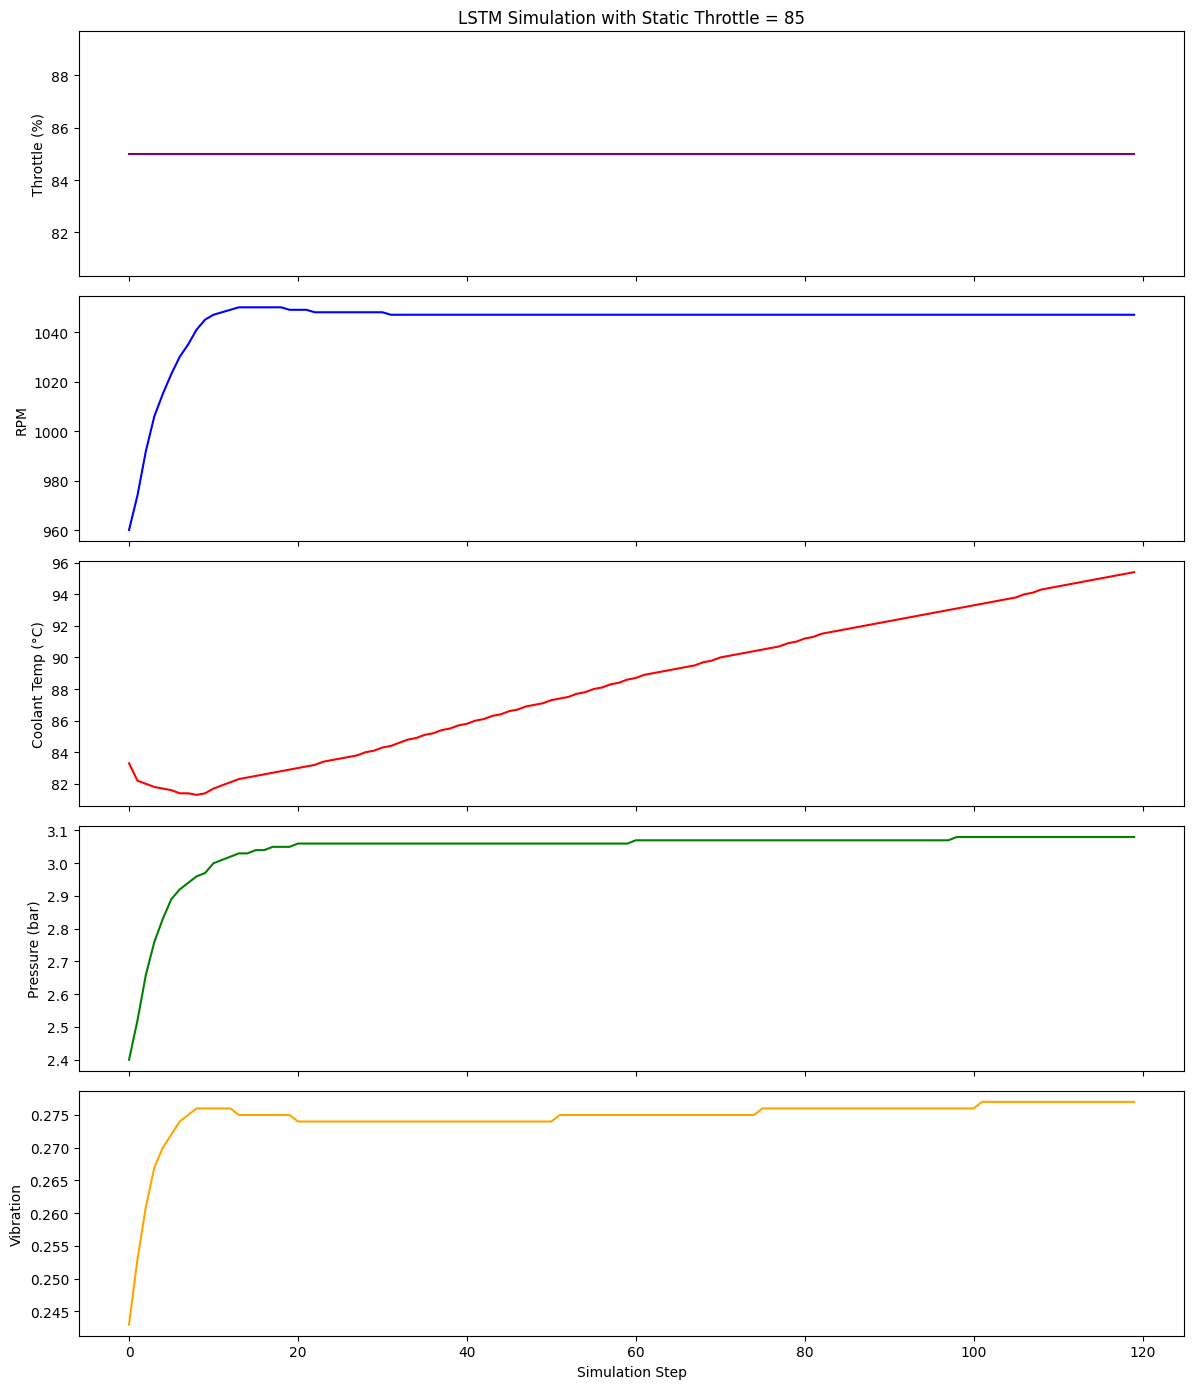

In [51]:
# Make sure window_size matches what LSTM was trained on
window_size = model.input_shape[1]
initial_window = df.iloc[300:300+window_size].to_dict(orient="records")

# Simulate with throttle = 85 for 120 steps
df_sim = simulate_engine_lstm(
    initial_window=initial_window,
    model=model,
    input_scaler=input_scaler,
    target_scaler=target_scaler,
    steps=120,
    throttle_override=85,
    input_features=input_features,
    target_features=target_features
)

# Plot results
plot_simulation_lstm(df_sim, title="LSTM Simulation with Static Throttle = 85")


In [52]:
def simulate_engine_lstm_dynamic(
    initial_window,
    model,
    input_scaler,
    target_scaler,
    throttle_sequence,
    input_features=None,
    target_features=None
):
    """
    Simulates engine behavior using LSTM model with a throttle sequence (list).
    Returns DataFrame of predicted states.
    """
    assert len(initial_window) >= model.input_shape[1], "Initial window too small"
    assert len(throttle_sequence) > 0, "Throttle sequence must be non-empty"

    history = initial_window.copy()
    results = []

    for throttle in throttle_sequence:
        next_state = predict_next_state_lstm(
            history_window=history,
            model=model,
            input_scaler=input_scaler,
            target_scaler=target_scaler,
            override_throttle=throttle,
            input_features=input_features,
            target_features=target_features
        )
        next_state["throttle_pos"] = throttle
        results.append(next_state)

        # Update sliding window
        history.pop(0)
        history.append(next_state)

    return pd.DataFrame(results)


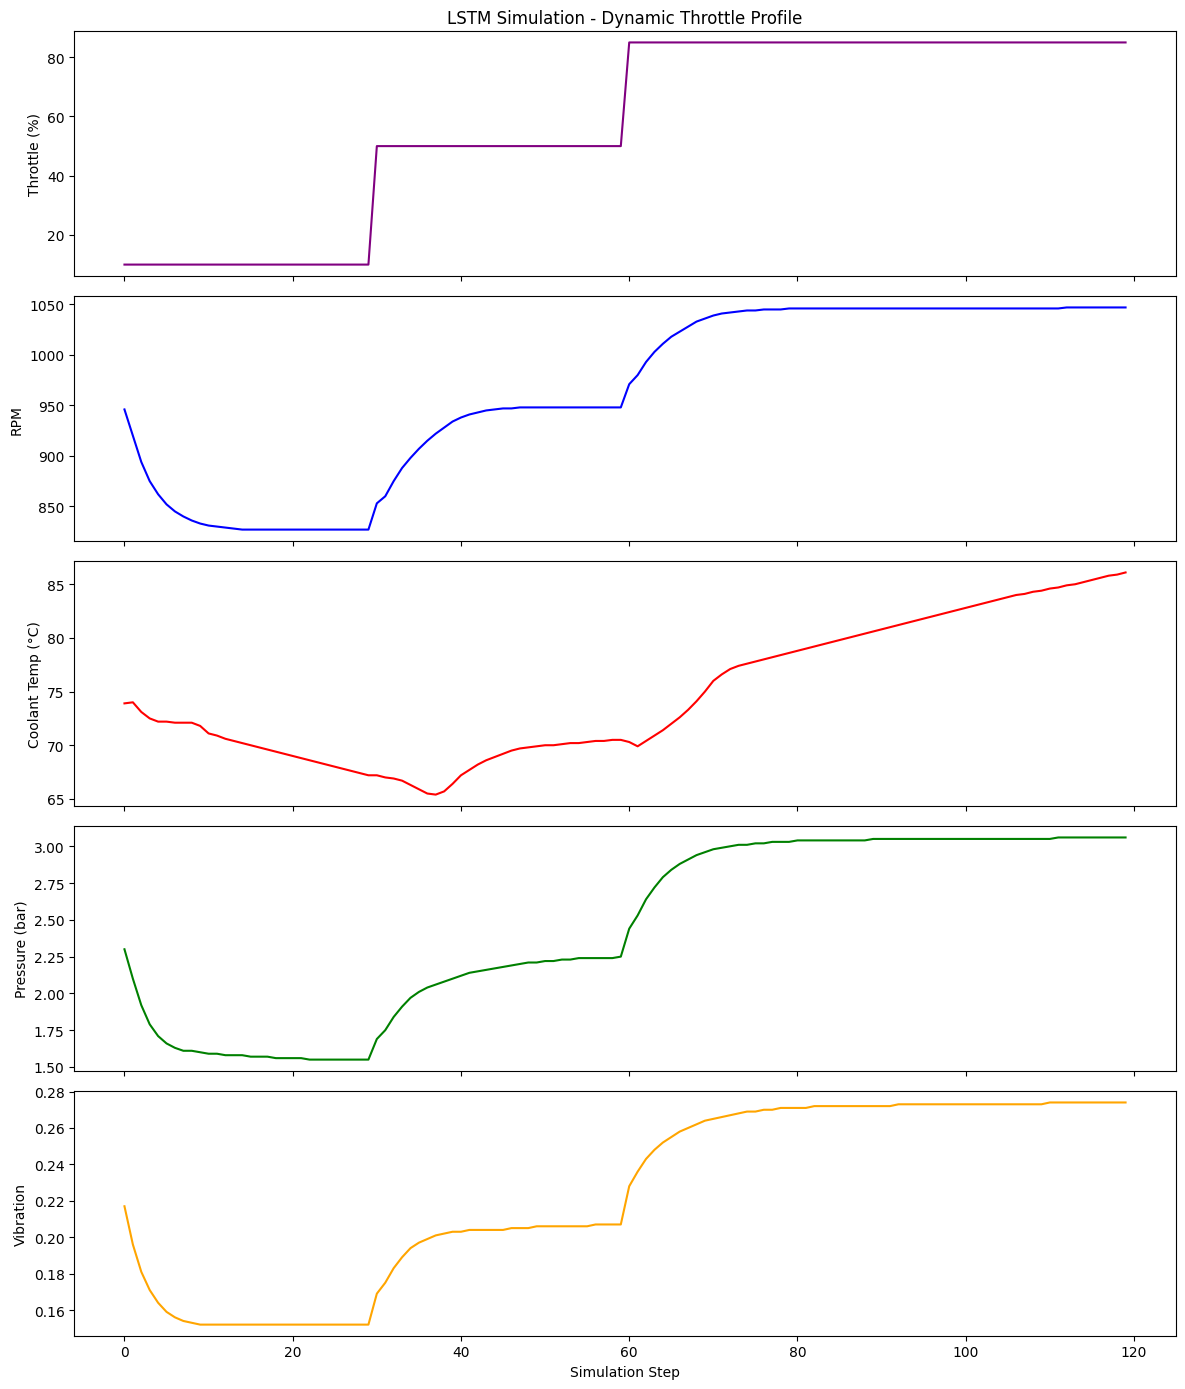

In [53]:
# Create a throttle sequence — ramp-up and hold
throttle_sequence = [10]*30 + [50]*30 + [85]*60  # Total 120 steps

# Initial input window
window_size = model.input_shape[1]
initial_window = df.iloc[400:400+window_size].to_dict(orient="records")

# Simulate
df_sim_dynamic = simulate_engine_lstm_dynamic(
    initial_window=initial_window,
    model=model,
    input_scaler=input_scaler,
    target_scaler=target_scaler,
    throttle_sequence=throttle_sequence,
    input_features=input_features,
    target_features=target_features
)

# Plot results
plot_simulation_lstm(df_sim_dynamic, title="LSTM Simulation - Dynamic Throttle Profile")
